
### Spatial Interpolation

Spatial interpolation is used to predicts values for cells in a raster from a limited number of sample data points around it. We are studying streaming high frequency temperature data in Chicago retrieved from Array of Thing (AoT).

Kriging is a family of estimators used to interpolate spatial data. This family includes ordinary kriging, universal kriging, indicator kriging, co-kriging and others (Taken from Lefohn et al., 2005). The choice of which kriging to use depends on the characteristics of the data and the type of spatial model desired. The most commonly used method is ordinary kriging, which was selected for this study. Reference:

Lefohn, Allen S. ; Knudsen, H. Peter; and Shadwick, Douglas S. 2005. Using Ordinary Kriging to Estimate the Seasonal W126, and N100 24-h Concentrations for the Year 2000 and 2003. A.S.L. & Associates, 111 North Last Chance Gulch Suite 4A Helena , Montana 59601. contractor_2000_2003.pdf


In [1]:
# !pip install pykrige
# !pip install osmnx

In [2]:
import osmnx as ox
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.2.2'

In [3]:
# from some place name, create a GeoDataFrame containing the geometry of the place
city = ox.gdf_from_place('Chicago, IL')
print (city)
# save the retrieved data as a shapefile
ox.save_gdf_shapefile(city)

                                            geometry  \
0  POLYGON ((-87.94010 42.00093, -87.94003 41.998...   

                                      place_name  bbox_north  bbox_south  \
0  Chicago, Cook County, Illinois, United States    42.02304   41.644531   

   bbox_east  bbox_west  
0 -87.524081 -87.940101  


/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


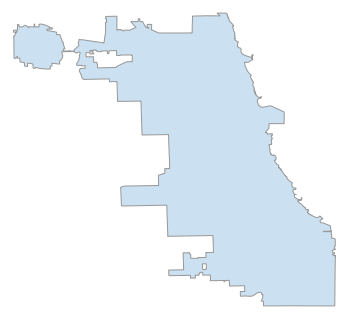

In [4]:
fig, ax = ox.plot_shape(city)

### Spatial Interpolation
The pykrige is a Kriging Toolkit for Python. The code supports 2D and 3D ordinary and universal kriging. Standard variogram models (linear, power, spherical, gaussian, exponential) are built in.

In [5]:
import numpy as np
import pandas as pd
import glob
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch


### Show the points available in Chicago with accurate data

Read sensor data in the CSV file, including the sensor ID, latitude, longitude and tempreture.


In [8]:
# uncomment to get from CSV
data = pd.read_csv(
     'sensors.csv',
     delim_whitespace=False, header=None,
     names=["ID","Lat", "Lon", "Z"])
#data = pd.DataFrame(dd)
data.head(len(data))

,ID,Lat,Lon,Z
0,001e0610ba46,41.878377,-87.627678,28.24
1,001e0610ba13,41.751238,-87.712990,19.83
2,001e0610bc10,41.736314,-87.624179,26.17
3,001e0610ba15,41.722457,-87.575350,45.70
4,001e0610bbe5,41.736495,-87.614529,35.07
5,001e0610ee36,41.751295,-87.605288,36.47
6,001e0610ee5d,41.923996,-87.761072,22.45
7,001e06113ad8,41.866786,-87.666306,125.01
8,001e0611441e,41.808594,-87.665048,19.82
9,001e06112e77,41.786756,-87.664343,26.21


2） Data processing part, if the tempreture is greater than 45, then set the data be 45

In [9]:
lons=np.array(data['Lon']) 
lats=np.array(data['Lat']) 
zdata=np.array(data['Z'])
print (zdata)

#If some data are greate than 50, then 
for r in range(len(zdata)):
    if zdata[r]>50:
        zdata[r] = 45

print (zdata)

[ 28.24  19.83  26.17  45.7   35.07  36.47  22.45 125.01  19.82  26.21
  22.04  20.2   20.5   42.15  21.67  25.14 125.01  21.16  19.5   21.61
  32.03  28.3   20.11  40.6   42.8   31.46  21.35  21.99  21.62  20.88
  20.55  20.41]
[28.24 19.83 26.17 45.7  35.07 36.47 22.45 45.   19.82 26.21 22.04 20.2
 20.5  42.15 21.67 25.14 45.   21.16 19.5  21.61 32.03 28.3  20.11 40.6
 42.8  31.46 21.35 21.99 21.62 20.88 20.55 20.41]



### Use ordinary kriging to do the spatial interpolation

In order to run spatial interpolation, we should define the boundary for the Chicago. Get the bounday value from the shapefile.


In [10]:
import geopandas as gpd
Chicago_Boundary_Shapefile = './data/il-chicago/il-chicago.shp'
boundary = gpd.read_file(Chicago_Boundary_Shapefile)

# get the boundary of Chicago 
xmin, ymin, xmax, ymax = boundary.total_bounds

### Generate the grids for longitude and lantitude, the number of bins is 100

In [11]:
xmin = xmin-0.01
xmax = xmax+0.01

ymin = ymin-0.01
ymax = ymax+0.01

grid_lon = np.linspace(xmin, xmax, 100)
grid_lat = np.linspace(ymin, ymax, 100)


### Run the OrdinaryKriging method, the variogram_model is gaussian

In [12]:
OK = OrdinaryKriging(lons, lats, zdata, variogram_model='gaussian', verbose=True, enable_plotting=False,nlags=20)
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)
print (z1)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 23.13242943543775
Full Sill: 93.76725754598041
Range: 0.3088207463280872
Nugget: 70.63482811054267 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

[[27.929639299995177 27.885804860591122 27.840219977527113 ...
  31.38644440999482 31.404557120037666 31.415939599753994]
 [27.905897248837668 27.86068404921839 27.81366980658623 ...
  31.441651243340107 31.460520427882592 31.47249459981318]
 [27.882113049771927 27.835522764862635 27.787081086840058 ...
  31.494391312029425 31.514039987495046 31.5266322253453]
 ...
 [29.13076186812433 29.1552093120318 29.180116129865915 ...
  29.04941113458729 29.041976478374846 29.034403311357586]
 [29.13587152661296 29.16061358719373 29.18582829738906 ...
  29.03941088416862 29.031640290800567 29.023775250651518]
 [29.139754022928745 29.164725892334754 29.190181873390763 ...
  29.0

### Plot the spatial interpolation result with ordinary kriging using 'gaussian' variogram model

Generate the result and the legend

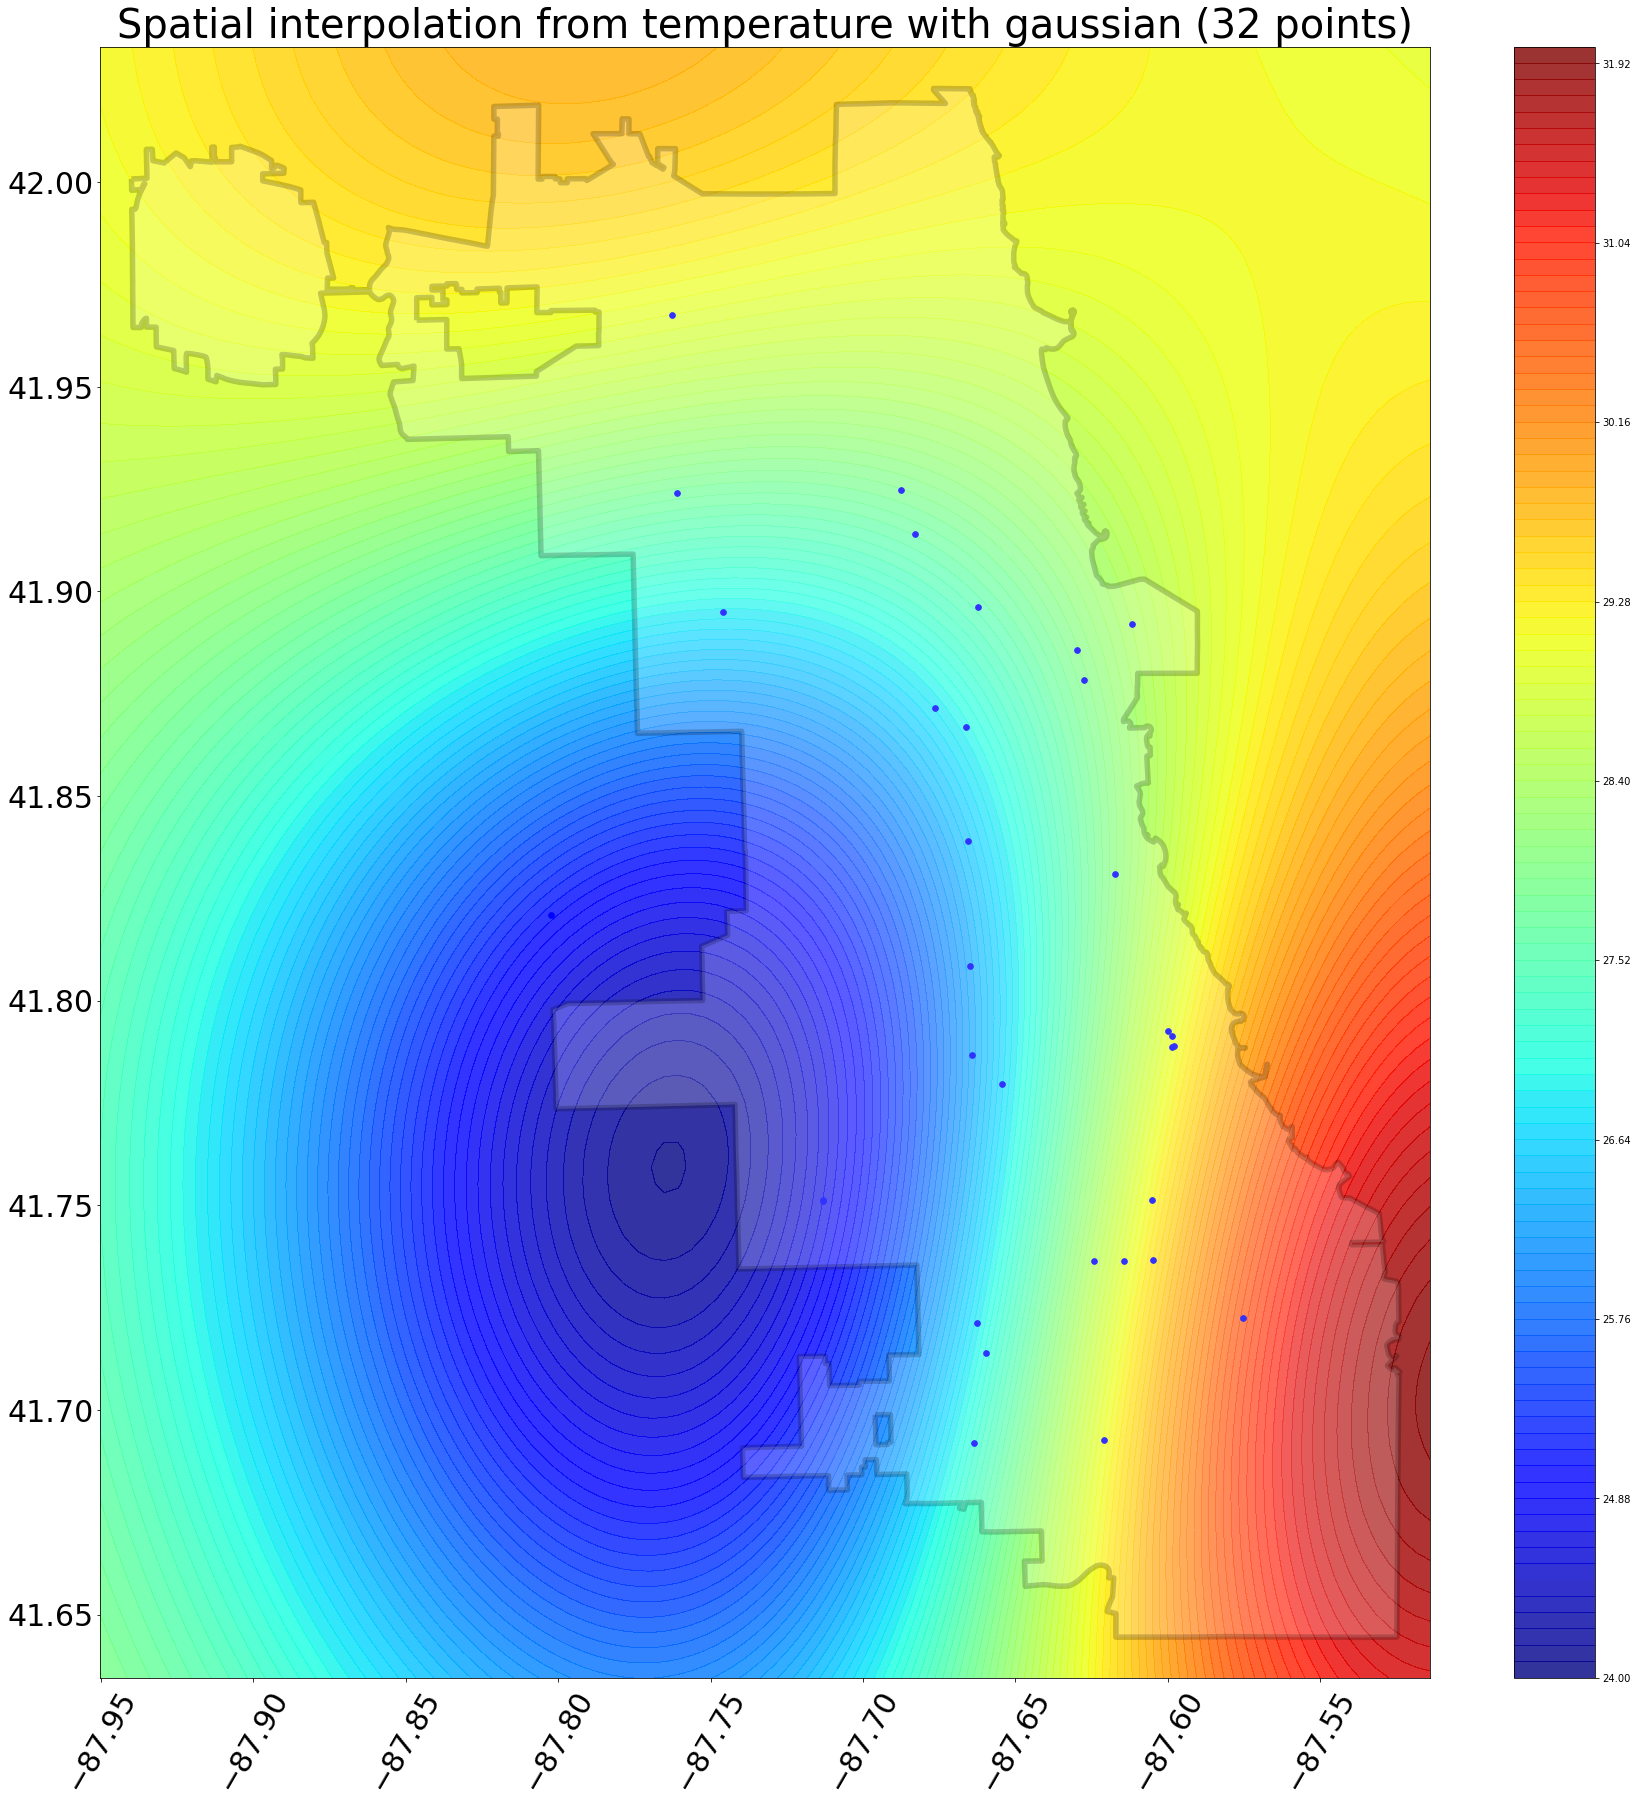

In [13]:
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(30,30))


#ax.scatter(lons, lats, s=len(lons), label='Input data')
boundarygeom = boundary.geometry

contour = plt.contourf(xintrp, yintrp, z1,len(z1),cmap=plt.cm.jet,alpha = 0.8) 


plt.colorbar(contour)


boundary.plot(ax=ax, color='white', alpha = 0.2, linewidth=5.5, edgecolor='black', zorder = 5)


npts = len(lons)

plt.scatter(lons, lats,marker='o',c='b',s=npts)

#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)

plt.xticks(fontsize = 30, rotation=60)
plt.yticks(fontsize = 30)

#Tempreture
plt.title('Spatial interpolation from temperature with gaussian (%d points)' % npts,fontsize = 40)
plt.show()
#ax.plot(grid_lon, grid_lat, label='Predicted values')

### Run the OrdinaryKriging method, the variogram_model is gaussian

In [14]:
OK = OrdinaryKriging(lons, lats, zdata, variogram_model='linear', verbose=True, enable_plotting=False,nlags=20)
z2, ss1 = OK.execute('grid', grid_lon, grid_lat)
#print (z2)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 78.08683566517114
Nugget: 69.86456627617994 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...




### Plot the spatial interpolation result with ordinary kriging using 'linear' variogram model

Generate the result and the legend


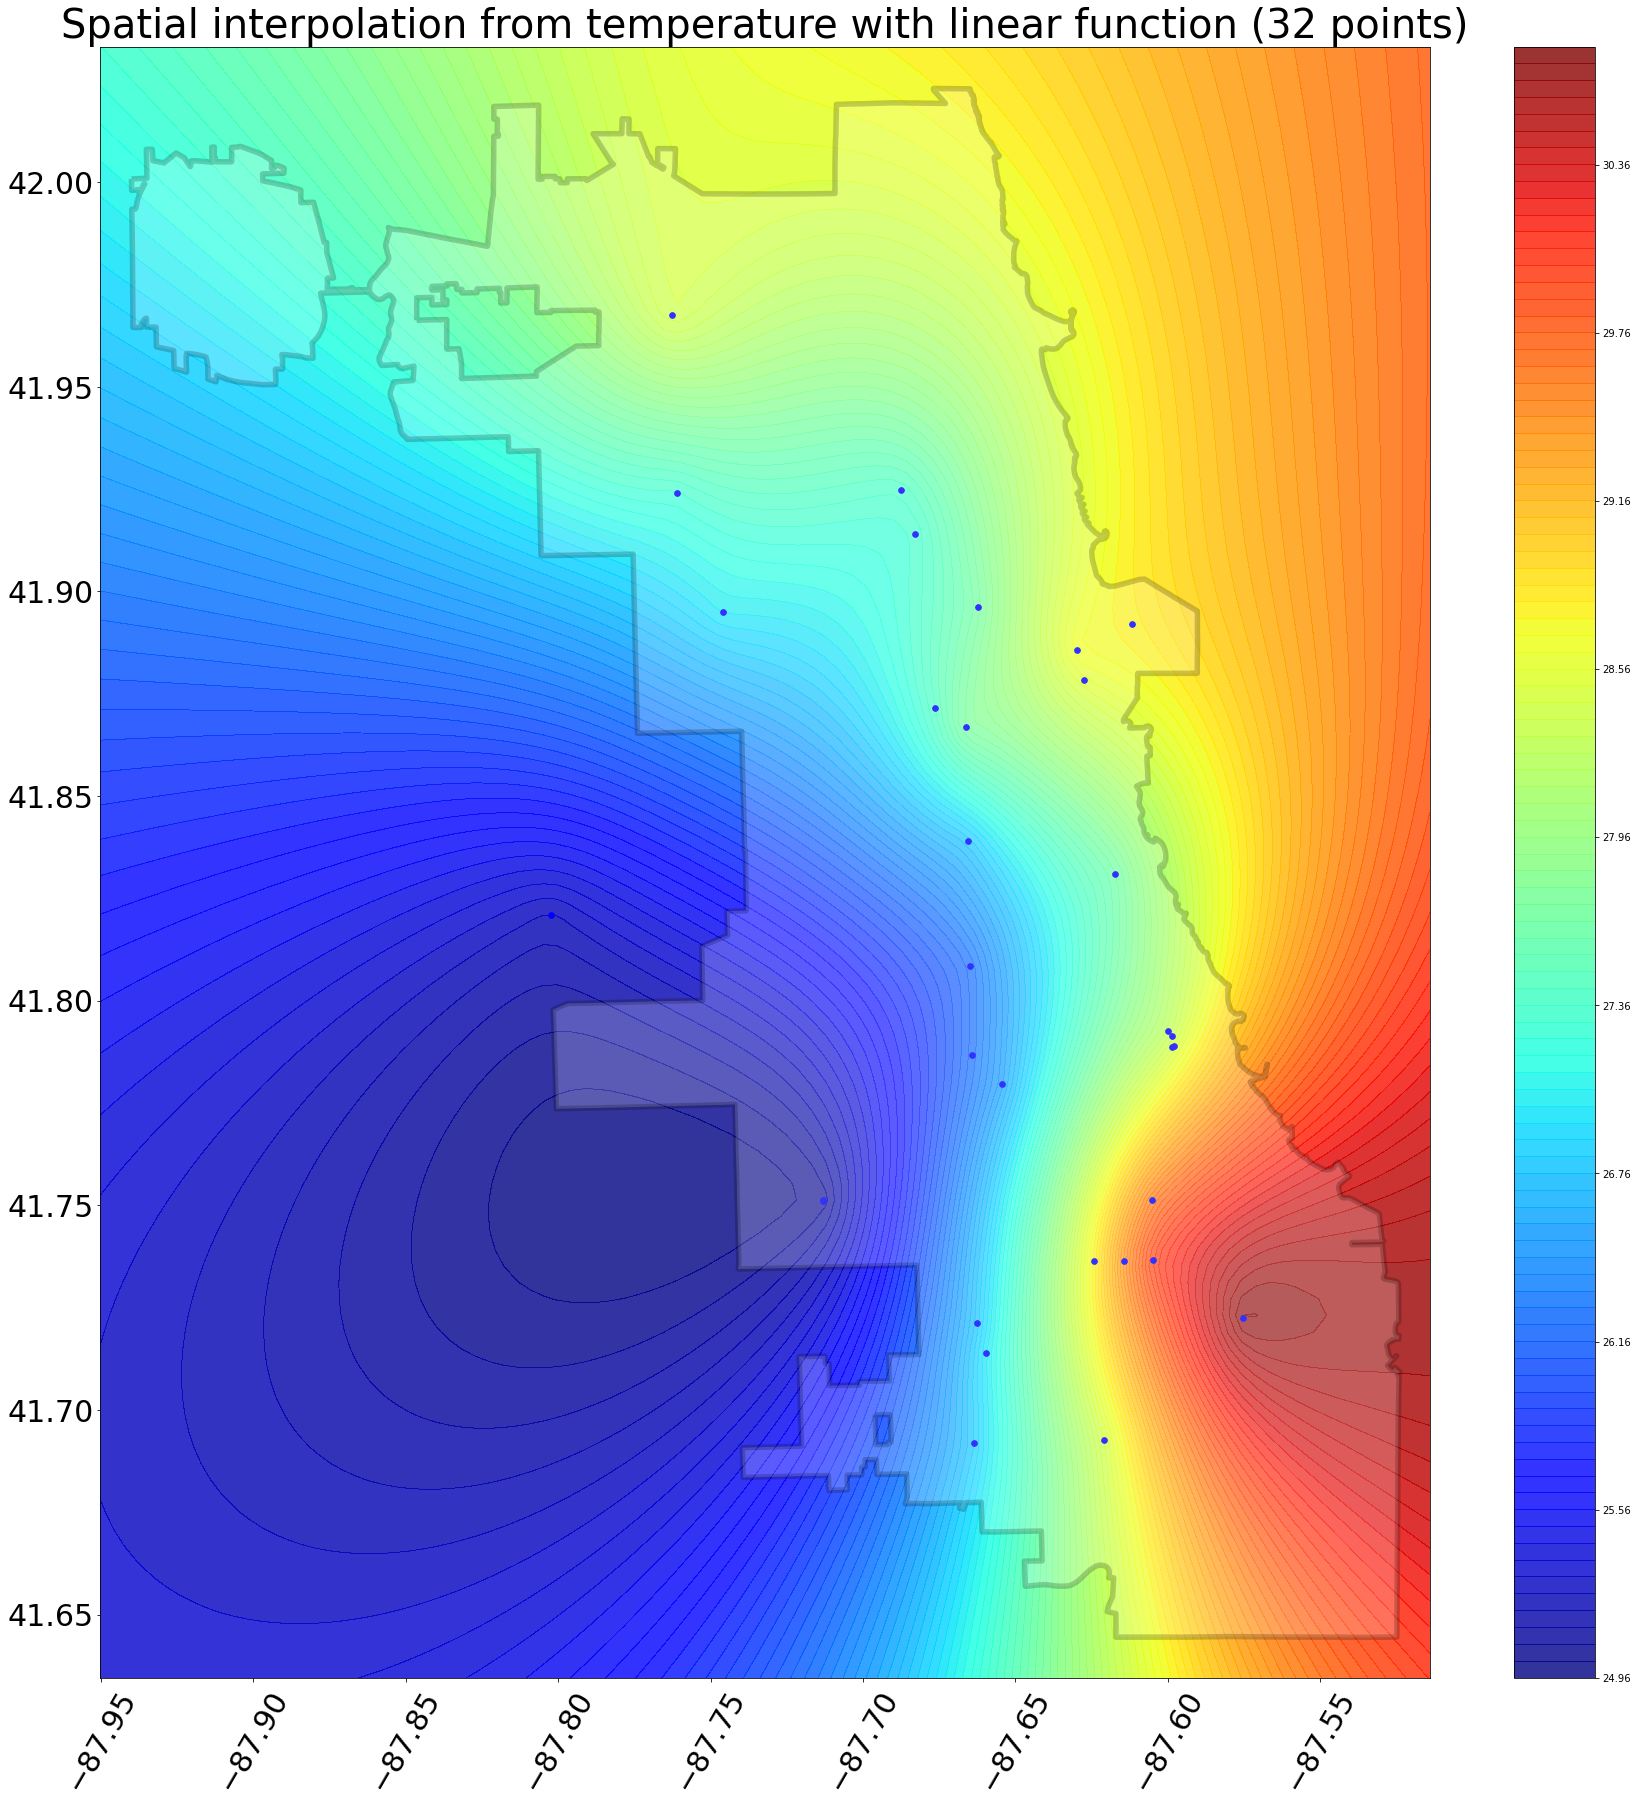

In [15]:
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(30,30))


#ax.scatter(lons, lats, s=len(lons), label='Input data')
boundarygeom = boundary.geometry

contour = plt.contourf(xintrp, yintrp, z2,len(z2),cmap=plt.cm.jet,alpha = 0.8) 


plt.colorbar(contour)


boundary.plot(ax=ax, color='white', alpha = 0.2, linewidth=5.5, edgecolor='black', zorder = 5)


npts = len(lons)

plt.scatter(lons, lats,marker='o',c='b',s=npts)

#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)

plt.xticks(fontsize = 30, rotation=60)
plt.yticks(fontsize = 30)

#Tempreture
plt.title('Spatial interpolation from temperature with linear function (%d points)' % npts,fontsize = 40)
plt.show()
#ax.plot(grid_lon, grid_lat, label='Predicted values')